In [1]:
import sys
sys.path.append("\..")

from lava.proc.lif.process import LIF
from lava.lib.dnf.connect.connect import connect
from lava.lib.dnf.operations.operations import Weights
from lava.lib.dnf.kernels.kernels import MultiPeakKernel
from lava.lib.dnf.operations.operations import Convolution
from lava.lib.dnf.kernels.kernels import SelectiveKernel
from lava.proc.io.source import RingBuffer

from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.lib.dnf.inputs.gauss_pattern.process import GaussPattern
from lava.lib.dnf.inputs.rate_code_spike_gen.process import RateCodeSpikeGen
from lava.proc.monitor.process import Monitor
import scipy.sparse


import matplotlib.pyplot as plt

import numpy as np

In [2]:
k_size=10
old_shape = np.array([180, 240])
img_shape = (old_shape / k_size).astype(int)
depthsxmeter = 10
d_range = [0.0, 2.5]

n_depths = int((d_range[1] - d_range[0]) * depthsxmeter)
shape = (img_shape[0], img_shape[1], n_depths)
print(shape)

(18, 24, 25)


In [3]:
def subsamples(data, k_size):
    new_shape = (
        int(data.shape[0] / k_size),
        k_size,
        int(data.shape[1] / k_size),
        k_size)
    data_reshape = data.reshape(new_shape)
    
    return np.nanmean(data_reshape.swapaxes(1 , 2), axis=(-1, -2))

In [4]:
time_steps = 1000
t_start = 2000

# input_buffer = np.zeros((shape[0], shape[1], shape[2], time_steps))
# input_buffer[5, 5, 5, :] = 1
# print(input_buffer.shape)

samples = np.load("samples_slider.npy", allow_pickle=True)
print(samples.shape)

samples_np = np.zeros((old_shape[0], old_shape[1], samples.size))

for i, s in enumerate(samples):
    samples_np[:,:, i] = s.toarray()
    
input_buffer = np.zeros((shape[0], shape[1], shape[2], time_steps))
samp = samples_np[:,:, t_start:t_start+time_steps:1]

for i in range(samp.shape[-1]):
    test = samp[:,:,i]
    test[test == 0] = np.nan
    
    test_sub = subsamples(test, k_size)
    
    data_s = scipy.sparse.csr_matrix(test_sub[:])

    y, x, d = scipy.sparse.find(data_s)
    y = y[d<d_range[1]]
    x = x[d<d_range[1]]
    d = d[d<d_range[1]]
    d = (((d - d_range[0]) / (d_range[1] - d_range[0])) * n_depths).astype(int)
    input_buffer[y, x, d, i] = 1

print(input_buffer.shape)
input_proc = RingBuffer(input_buffer)

(5592,)


C:\Users\schiavaz\AppData\Local\Temp/ipykernel_18900/3731186443.py:9: RuntimeWarning: Mean of empty slice
  return np.nanmean(data_reshape.swapaxes(1 , 2), axis=(-1, -2))


(18, 24, 25, 1000)


<IPython.core.display.Javascript object>


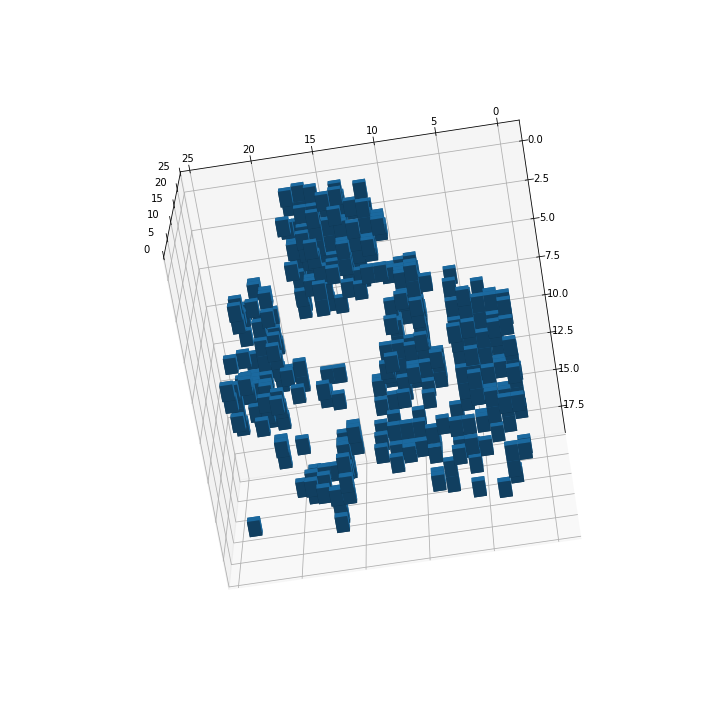

In [42]:
t = input_buffer[:, :, :, 200:210].sum(axis=-1)

%matplotlib notebook
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
ax.voxels(t);

In [6]:
dnf = LIF(shape=shape, du=0.12, dv=0.5, vth=10)

kernel = MultiPeakKernel(amp_exc=5,
                         width_exc=[3, 3, 8],
                         amp_inh=-15,
                         width_inh=[1, 1, 10])
connect(dnf.s_out, dnf.a_in, [Convolution(kernel)])
connect(input_proc.s_out, dnf.a_in, [Weights(6)])

In [7]:

monitor = Monitor()
monitor.probe(dnf.s_out, time_steps)

# monitor_v = Monitor()
# monitor_v.probe(dnf.v, time_steps)

# monitor_u = Monitor()
# monitor_u.probe(dnf.u, time_steps)

# Run the DNF
dnf.run(condition=RunSteps(num_steps=time_steps),
        run_cfg=Loihi1SimCfg(select_tag='floating_pt'))

# Get probed data from monitor
probed_data = monitor.get_data()
# probed_data_v = monitor_v.get_data()
# probed_data_u = monitor_u.get_data()

# Stop the execution after getting the monitor's data
dnf.stop()

In [31]:
t = probed_data[dnf.name][dnf.s_out.name][800:850,:,:,:].sum(axis=(0))
np.save("out_slider.npy", probed_data[dnf.name][dnf.s_out.name])

In [32]:
# t = input_buffer[:, :, :, 0:50].sum(axis=-1)

<IPython.core.display.Javascript object>


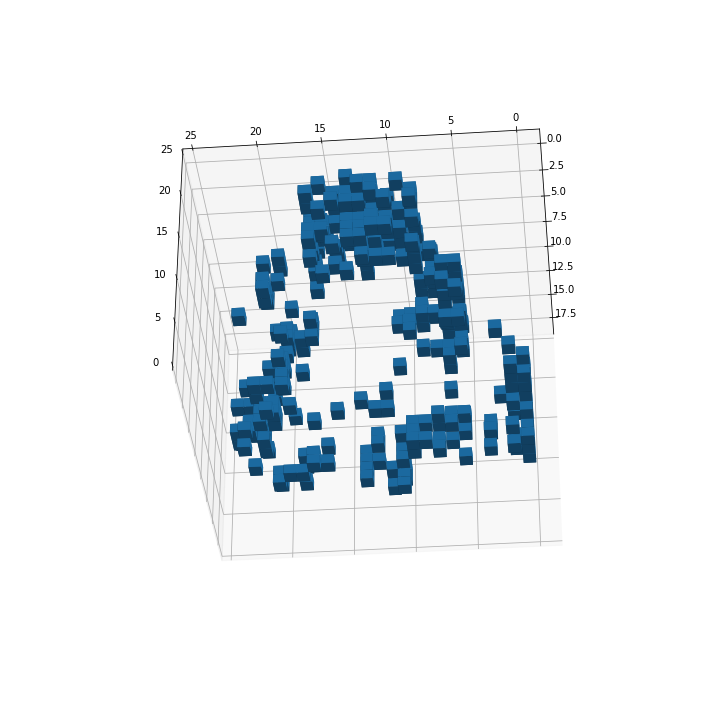

In [33]:
%matplotlib notebook
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
ax.voxels(t);

In [11]:
v = np.zeros_like(t)

In [12]:
for i in range(v.shape[-1]):
    v[:, :, i] = (i / n_depths) * (d_range[1] - d_range[0]) + d_range[0]

In [13]:
test = t * v

In [14]:
test.shape

(18, 24, 25)

C:\Users\schiavaz\AppData\Local\Temp/ipykernel_18900/437418882.py:4: RuntimeWarning: Mean of empty slice
  m = plt.imshow(np.nanmean(test, axis=-1), interpolation="none", cmap="jet_r", vmax=d_range[1], vmin=d_range[0])


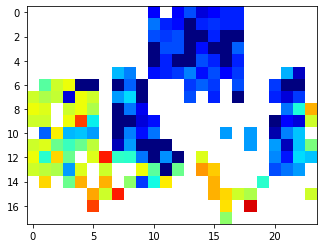

In [15]:
%matplotlib inline
# plt.figure(figsize=(5, 5))
test[test == 0] = np.nan
m = plt.imshow(np.nanmean(test, axis=-1), interpolation="none", cmap="jet_r", vmax=d_range[1], vmin=d_range[0])
# plt.colorbar(m)

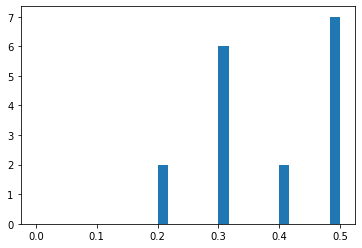

In [16]:
plt.hist(test.flatten(), 30, range=(0, 0.5));

In [17]:
input_buffer.shape

(18, 24, 25, 1000)

In [36]:
input_x = input_buffer[2, 12, :, :]

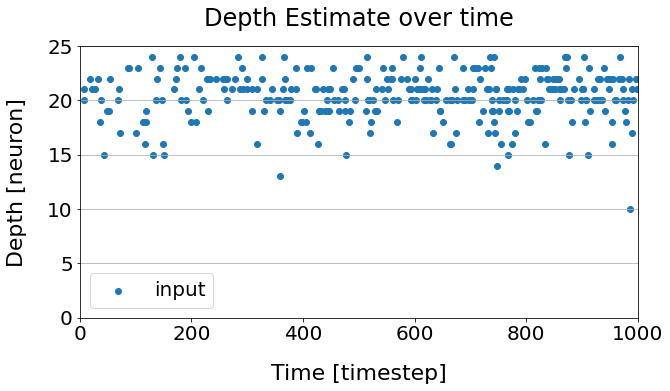

In [37]:
%matplotlib inline
data_s = scipy.sparse.csr_matrix(input_x.transpose())

t_in, v_in, _ = scipy.sparse.find(data_s)

plt.figure(figsize=(10, 5))
plt.scatter(t_in, v_in, label="input")
plt.legend(fontsize=20)
plt.xlabel("Time [timestep]", fontsize=22, labelpad=20)
plt.ylabel("Depth [neuron]", fontsize=22, labelpad=20)
plt.title("Depth Estimate over time", fontsize=24, pad=20)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.ylim([0, n_depths])
plt.xlim([0, time_steps])
# print(results.times[1226])
plt.grid(axis="y")

In [38]:
data_out = probed_data[dnf.name][dnf.s_out.name]
# data_out = np.load("out_top.npy")
data_out.shape

(1000, 18, 24, 25)

In [39]:
output_x = data_out[:, 2, 12, :]

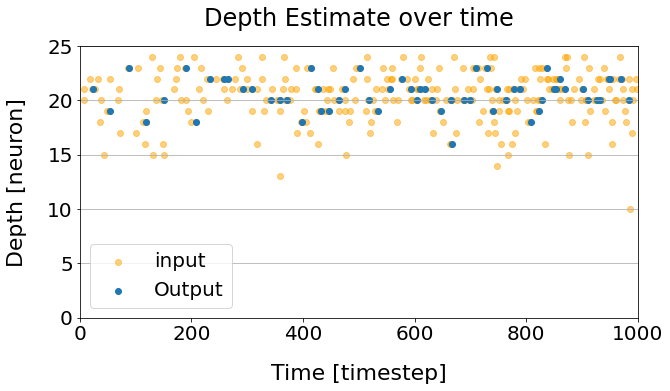

In [40]:
%matplotlib inline
data_s = scipy.sparse.csr_matrix(output_x)

t_out, v_out, _ = scipy.sparse.find(data_s)

plt.figure(figsize=(10, 5))
plt.scatter(t_in, v_in, label="input", alpha=0.5, color="orange")
plt.scatter(t_out, v_out, label="Output")
plt.legend(fontsize=20)
plt.xlabel("Time [timestep]", fontsize=22, labelpad=20)
plt.ylabel("Depth [neuron]", fontsize=22, labelpad=20)
plt.title("Depth Estimate over time", fontsize=24, pad=20)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.ylim([0, n_depths])
plt.xlim([0, time_steps])
# print(results.times[1226])
plt.grid(axis="y")

In [23]:
np.save("out_top.npy", data_out)

In [24]:

%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("..")
import gtd2d.plotter.plotter as plot
import pickle
import open3d as o3d


path = "C:/Users/schiavaz/lava-nc/depth/"
dataset = "data/slider-depth/"

with open(path + dataset + 'results/result.pkl', 'rb') as f:
    out = pickle.load(f)

results = plot.Plotter(out, base_path=path + dataset)
print(results.times.shape)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Errno 2] No such file or directory: 'C:/Users/schiavaz/lava-nc/depth/data/slider-depth/gt_depths.npy'
(5592,)


In [25]:
test = data_out * v
out_sparse = []
for i in test:
    i[i == 0] = np.nan
    img = np.nanmean(i, axis=-1)
    s = scipy.sparse.csr_matrix(img)
    out_sparse.append(s)

C:\Users\schiavaz\AppData\Local\Temp/ipykernel_18900/2916453354.py:5: RuntimeWarning: Mean of empty slice
  img = np.nanmean(i, axis=-1)


In [26]:
results.raw_depths_sparse = out_sparse
results.shape = (36, 49)
results.cam_calib /= k_size

In [27]:
p3d = results.plot_open3d("raw", z=2, v_range=(0, 3), id_range=(0, -1), cmap="jet_r")

100%|██████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1375.44it/s]


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
